In [149]:
import json 
import os
import logging 
import concurrent 
import asyncio 
import re 
import requests 

from collections import deque 
from itertools import chain 

from pprint import PrettyPrinter

from subgrounds import Subgrounds
from palettable.tableau import Tableau_20
from palettable.mycarta import Cube1_4, Cube1_8

from web3 import Web3
from web3.exceptions import ContractLogicError

# apis / networking 
from etherscan import Etherscan
from pycoingecko import CoinGeckoAPI

import pandas as pd 
import numpy as np 
import altair as alt 


from flywheel_util.constants import addresses, url_subgraphs
from flywheel_util.utils import (
    ddf, 
    remove_prefix, 
    query_attrs, 
    camel_to_snake, 
    df_cols_camel_to_snake, 
    df_cols_change_prefix, 
    cg_get_market_history, 
)
from flywheel_util.w3_utils import (
    verified_contract, 
    get_total_supply_of_erc20,
    get_account_balance_of_erc20, 
    get_erc20_balance_for_all_accounts, 
) 


# logging.basicConfig(level=logging.INFO)

VALIDATE = True  

pp = PrettyPrinter().pprint

alt.data_transformers.disable_max_rows()
alt.renderers.enable('jupyterlab')

RendererRegistry.enable('jupyterlab')

In [150]:
colors_24 = Tableau_20.hex_colors + Cube1_4.hex_colors
colors_28 = Tableau_20.hex_colors + Cube1_8.hex_colors

In [151]:
URL_INFURA = 'https://mainnet.infura.io/v3/856c3834f317452a82e25bb06e04de18'
w3 = Web3(Web3.HTTPProvider(URL_INFURA))
cg = CoinGeckoAPI()
hmmmm = 'VR7YA9DRDB4Y15B5N3WU9E7PSJ9RWPCP5S'
etherscan = Etherscan(hmmmm)

In [152]:
URL_CURVE_POOLS = 'https://api.thegraph.com/subgraphs/name/convex-community/curve-pools'
URL_CURVE_DAO = 'https://api.thegraph.com/subgraphs/name/convex-community/curve-dao'

# Tokens 
ADDRESS_frxETH = "0x5E8422345238F34275888049021821E8E08CAa1f".lower()
ADDRESS_frxETHCRV = '0xf43211935c781d5ca1a41d2041f397b8a7366c7a'.lower()
ADDRESS_frxETHCRV_GAUGE_DEPOSIT = '0x2932a86df44fe8d2a706d8e9c5d51c24883423f5'.lower()
ADDRESS_cvxfrxETHCRV = '0xC07e540DbFecCF7431EA2478Eb28A03918c1C30E'.lower()
ADDRESS_FRAX_FARM_stkcvxfrxETHETH = '0xa537d64881b84faffb9Ae43c951EEbF368b71cdA'.lower()

# Contracts 
ADDRESS_CONVEX_BASE_REWARDS_POOL = '0xbD5445402B0a287cbC77cb67B2a52e2FC635dce4'.lower()
ADDRESS_CONVEX_VOTER_PROXY = '0x989aeb4d175e16225e39e87d0d97a3360524ad80'.lower()
ADDRESS_CURVE_POOL_FRXETH_ETH = '0xa1f8a6807c402e4a15ef4eba36528a3fed24e577'.lower()
ADDRESS_CONVEX_STAKING_WRAPPER_FRAX = '0x4659d5fF63A1E1EDD6D5DD9CC315e063c95947d0'.lower() 

# Analysis of Holders of frxETHCRV 

frxETHCRV is the liquidity pool token for the [frxETH:ETH pool](https://curve.fi/#/ethereum/pools/frxeth/deposit) on curve. 

Tracking which users hold frxETHCRV is not as simple as checking the total amount of this token across user accounts. 
There are various platforms where users can stake frxETHCRV in exchange for derivative tokens. This hierarchical outline
shows the various places where the supply of frxETHCRV exists within the ecosystem. 

**Contracts**: 
- Curve 
    - [frxETH:ETH curve pool](https://curve.fi/#/ethereum/pools/frxeth/deposit)
- Convex 
    - [Booster](https://docs.convexfinance.com/convexfinanceintegration/booster)
        - The curve deposit contract for curve LP tokens. 
        - User receives a deposit receipt token prefixed with "cvx". 
    - [BaseRewardPool](https://docs.convexfinance.com/convexfinanceintegration/baserewardpool)
        - The main reward contract for all LP pools.
        - User does not receive a deposit / staking token, simply updates an internal balance. 
    - [StakingWrapperFrax](https://etherscan.io/address/0x4659d5fF63A1E1EDD6D5DD9CC315e063c95947d0)
        - The frax deposit contract for curve LP tokens. 
 

**Tokens** 
- [frxETHCRV](https://etherscan.io/token/0xf43211935c781d5ca1a41d2041f397b8a7366c7a)
- [cvxfrxETHCRV](https://etherscan.io/token/0xC07e540DbFecCF7431EA2478Eb28A03918c1C30E)
- [stkcvxfrxETHCRV-frax](https://etherscan.io/token/0x4659d5ff63a1e1edd6d5dd9cc315e063c95947d0)

- frxETHCRV supply 
    - circulating frxETHCRV *(ignored for now since ~99.9% of frxETHCRV is not circulating, see [here](https://etherscan.io/token/0xf43211935c781d5ca1a41d2041f397b8a7366c7a#balances))*. 
    - staked in [curve gauge](0x2932a86df44fe8d2a706d8e9c5d51c24883423f5) for frxETH:ETH pool. 
        - User stakes directly in curve gauge (frxETHCRV -> frxETHCRV-gauge). 
        - User deposits frxETHCRV in convex curve (Booster contract) receiving cvxfrxETHCRV. 
            - Circulating cvxfrxETHCRV. 
            - User stakes into cvxfrxETHCRV rewards contract. No token is received but `Staked` event is emitted.
        - User deposits frxETHCRV in convex frax (Booster contract) receiving stkcvxfrxETHCRV-frax. Internally, convex holds cvxfrxETHCRV on the user's behalf in the base reward pool contract. 
            - User deposits stkcvxfrxETHCRV-frax into a convex vault, which manages interactions with the frax farm on behalf of the user. 
                - We can differentiate between frax farm deposits through frax / convex based on source address of staking events. 
            - User deposits stkcvxfrxETHCRV-frax into frax finance staking farm. 

In [153]:
def remove_nrows_with_value(df, value, key="account", nrows=1): 
    pre_len = len(df) 
    df = df.loc[df[key].str.lower() != value.lower()]
    assert len(df) == pre_len - nrows 
    return df 

In [177]:
sg = Subgrounds()
sg_curve_pools = sg.load_subgraph(url_subgraphs.convex.curve_pools)
sg_curve_dao = sg.load_subgraph(URL_CURVE_DAO) 

In [155]:
def get_curve_gauge_balances(): 
    # frxETHCRV staked in curve gauge by account. frxETHCRV -> frxETHCRV-gauge at 1:1 ratio 
    # ---------------------------------------------------------------------------------------------------------------------
    qattrs = ['id', 'provider', 'value']
    # deposits into gauge 
    df_deposits = query_attrs(
        sg, sg_curve_dao.Query.gaugeDeposits(first=100000, where={'gauge': ADDRESS_frxETHCRV_GAUGE_DEPOSIT}), qattrs
    )
    df_deposits = remove_prefix(df_deposits, 'gaugeDeposits_') 
    # withdawals from gauge 
    df_withdraws = query_attrs(
        sg, sg_curve_dao.Query.gaugeWithdraws(first=100000, where={'gauge': ADDRESS_frxETHCRV_GAUGE_DEPOSIT}), qattrs
    )
    df_withdraws = remove_prefix(df_withdraws, 'gaugeWithdraws_') 
    df_withdraws.value *= -1
    # Current deposited amount per address within gauge 
    df_curve = pd.concat([df_deposits, df_withdraws])
    df_curve = df_curve.groupby('provider')['value'].sum().reset_index()
    df_curve = df_curve.loc[df_curve.value != 0].sort_values('value', ascending=False).reset_index(drop=True)
    df_curve['platform'] = 'curve-gauge'
    df_curve.value /= 1e18
    return df_curve 

def validate_curve_gauge_balances(df_curve): 
    frxethCRV_curve_gauge = df_curve.value.sum()
    frxethCRV_curve_gauge_actual = get_account_balance_of_erc20(ADDRESS_frxETHCRV_GAUGE_DEPOSIT, ADDRESS_frxETHCRV)

    frxethCRV_convex_staked = df_curve.loc[df_curve.provider == ADDRESS_CONVEX_VOTER_PROXY].value.sum()
    frxethCRV_convex_staked_actual = get_account_balance_of_erc20(ADDRESS_CONVEX_VOTER_PROXY, ADDRESS_frxETHCRV_GAUGE_DEPOSIT)

    # Manual validation of frxETHCRV staked in curve gauge 
    # https://etherscan.io/token/0xf43211935c781d5ca1a41d2041f397b8a7366c7a?a=0x2932a86df44fe8d2a706d8e9c5d51c24883423f5
    print(f"Number of frxETHCRV deposited in curve gauge:\n\tComputed: {frxethCRV_curve_gauge:>19}\n\tActual: {frxethCRV_curve_gauge_actual:>21}")
    if VALIDATE: 
        np.testing.assert_almost_equal(frxethCRV_curve_gauge_actual, frxethCRV_curve_gauge, decimal=10)

    # Manual validation of frxETHCRV-gauge (1:1 with frxETHCRV) staked in convex 
    # https://etherscan.io/token/0x2932a86df44fe8d2a706d8e9c5d51c24883423f5?a=0x989aeb4d175e16225e39e87d0d97a3360524ad80
    print(f"Number of frxETHCRV-gauge held by convex voter proxy:\n\tComputed: {frxethCRV_convex_staked:>20}\n\tActual: {frxethCRV_convex_staked_actual:>22}")
    if VALIDATE: 
        np.testing.assert_almost_equal(frxethCRV_convex_staked_actual, frxethCRV_convex_staked, decimal=10)

    print(f"Percent of frxETHCRV staked in curve gauge through convex: {frxethCRV_convex_staked / frxethCRV_curve_gauge:%}")
    df_curve.head()

In [156]:
df_curve = get_curve_gauge_balances()

In [157]:
validate_curve_gauge_balances(df_curve)

Number of frxETHCRV deposited in curve gauge:
	Computed:  51492.258676220976
	Actual:     51492.25867622099
Number of frxETHCRV-gauge held by convex voter proxy:
	Computed:    50536.29275668419
	Actual:      50536.29275668419
Percent of frxETHCRV staked in curve gauge through convex: 98.143476%


In [158]:
def get_convex_staked_balances(): 
    # frxETHCRV staked in convex (curve system). frxETHCRV -> cvxfrxETHCRV at 1:1 ratio 
    # ---------------------------------------------------------------------------------------------------------------------
    qattrs = ['id', 'amount', 'timestamp', 'user.address']
    # deposits into the convex staking contract for curve lp tokens 
    q_deposits = sg_curve_pools.Query.deposits(first=100000, where={'poolid_': {'swap': ADDRESS_CURVE_POOL_FRXETH_ETH}})
    df_deposits = query_attrs(sg, q_deposits, qattrs)
    df_deposits = remove_prefix(df_deposits, 'deposits_') 
    # withdrawals from the convex staking contract for curve lp tokens 
    q_withdrawals = sg_curve_pools.Query.withdrawals(first=100000, where={'poolid_': {'swap': ADDRESS_CURVE_POOL_FRXETH_ETH}})
    df_withdrawals = query_attrs(sg, q_withdrawals, qattrs)
    df_withdrawals = remove_prefix(df_withdrawals, 'withdrawals_') 
    df_withdrawals.amount *= -1
    # current deposited amount per account in convex staking contract for curve lp tokens 
    df_convex = pd.concat([df_deposits, df_withdrawals])
    df_convex = df_convex.groupby('user_address')['amount'].sum().reset_index()
    df_convex = df_convex.loc[df_convex.amount != 0].sort_values('amount', ascending=False).reset_index(drop=True)
    df_convex.amount /= 1e18
    df_convex['platform'] = 'convex-curve'
    df_convex = df_convex.rename(columns={'user_address': 'account'})
    df_convex.head()
    return df_convex 

def validate_convex_staked_balances(df_convex): 
    # Ensure that the holdings of frxETHCRV-gauge by the convex voter proxy address are the same (computed in two ways) 
    # 1. Curve dao subgraph - aggregating curve gauge deposits and withdraws by address (convex voter proxy is one of them). 
    # 2. Convex curve pools subgraph - aggregating convex gauge deposits and withdawals by address. 
    # These numbers should be really close but sometimes might differ due to subgraph indexing speed. 
    convex_frxethcrv_1 = df_curve.loc[df_curve.provider == ADDRESS_CONVEX_VOTER_PROXY]['value'].values.tolist()[0]
    convex_frxethcrv_2 = df_convex.amount.sum()
    print(f"Number of frxETHCRV-gauge held by convex voter proxy (curve dao subgraph): {convex_frxethcrv_1:>26}")
    print(f"Number of frxETHCRV-gauge held by convex voter proxy (convex curve pool subgraph): {convex_frxethcrv_2}")
    if VALIDATE: 
        np.testing.assert_almost_equal(convex_frxethcrv_1, convex_frxethcrv_2, 10)

In [159]:
df_convex = get_convex_staked_balances()

In [160]:
validate_convex_staked_balances(df_convex)

Number of frxETHCRV-gauge held by convex voter proxy (curve dao subgraph):          50536.29275668419
Number of frxETHCRV-gauge held by convex voter proxy (convex curve pool subgraph): 50536.2927566842


In [161]:
def get_frax_staked_balances(): 
    # stkfrxETHCRV-frax staked in frax. frxETHCRV -> stkcvxfrxETHCRV-frax
    # ---------------------------------------------------------------------------------------------------------------------
    # These assets are held in the frax farm contract 
    contract_frax_farm = verified_contract(ADDRESS_FRAX_FARM_stkcvxfrxETHETH)
    logs_stake_locked = contract_frax_farm.events.StakeLocked.getLogs(fromBlock=0)
    logs_withdrawals = contract_frax_farm.events.WithdrawLocked.getLogs(fromBlock=0)
    logs_lock_additional = contract_frax_farm.events.LockedAdditional.getLogs(fromBlock=0)
    deposits = [{'account': d.args['user'], 'amount': d.args['amount'] / 1e18} for d in logs_stake_locked + logs_lock_additional]
    withdrawals = [{'account': d.args['user'], 'amount': -d.args['liquidity'] / 1e18} for d in logs_withdrawals]
    # We can determine which addresses correspond to convex staking proxy. These are users who are staking in the frax 
    # farm through convex for boosted FXS yield. 
    abi_convex_staking_proxy = '[{"inputs":[],"stateMutability":"nonpayable","type":"constructor"},{"inputs":[],"name":"FEE_DENOMINATOR","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"_rewardsAddress","type":"address"}],"name":"changeRewards","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"checkpointRewards","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"convexCurveBooster","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"convexDepositToken","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"crv","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"curveLpToken","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"cvx","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"earned","outputs":[{"internalType":"address[]","name":"token_addresses","type":"address[]"},{"internalType":"uint256[]","name":"total_earned","type":"uint256[]"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"feeRegistry","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"fxs","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"getReward","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"bool","name":"_claim","type":"bool"},{"internalType":"address[]","name":"_rewardTokenList","type":"address[]"}],"name":"getReward","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"bool","name":"_claim","type":"bool"}],"name":"getReward","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"_owner","type":"address"},{"internalType":"address","name":"_stakingAddress","type":"address"},{"internalType":"address","name":"_stakingToken","type":"address"},{"internalType":"address","name":"_rewardsAddress","type":"address"}],"name":"initialize","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"bytes32","name":"_kek_id","type":"bytes32"},{"internalType":"uint256","name":"_addl_liq","type":"uint256"}],"name":"lockAdditional","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"bytes32","name":"_kek_id","type":"bytes32"},{"internalType":"uint256","name":"_addl_liq","type":"uint256"}],"name":"lockAdditionalConvexToken","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"bytes32","name":"_kek_id","type":"bytes32"},{"internalType":"uint256","name":"_addl_liq","type":"uint256"}],"name":"lockAdditionalCurveLp","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"bytes32","name":"_kek_id","type":"bytes32"},{"internalType":"uint256","name":"new_ending_ts","type":"uint256"}],"name":"lockLonger","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"owner","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"poolRegistry","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"rewards","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"_proxy","type":"address"}],"name":"setVeFXSProxy","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_liquidity","type":"uint256"},{"internalType":"uint256","name":"_secs","type":"uint256"}],"name":"stakeLocked","outputs":[{"internalType":"bytes32","name":"kek_id","type":"bytes32"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_liquidity","type":"uint256"},{"internalType":"uint256","name":"_secs","type":"uint256"}],"name":"stakeLockedConvexToken","outputs":[{"internalType":"bytes32","name":"kek_id","type":"bytes32"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_liquidity","type":"uint256"},{"internalType":"uint256","name":"_secs","type":"uint256"}],"name":"stakeLockedCurveLp","outputs":[{"internalType":"bytes32","name":"kek_id","type":"bytes32"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"stakingAddress","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"stakingToken","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"usingProxy","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"vaultType","outputs":[{"internalType":"enum IProxyVault.VaultType","name":"","type":"uint8"}],"stateMutability":"pure","type":"function"},{"inputs":[],"name":"vaultVersion","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"pure","type":"function"},{"inputs":[],"name":"vefxsProxy","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"bytes32","name":"_kek_id","type":"bytes32"}],"name":"withdrawLocked","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"bytes32","name":"_kek_id","type":"bytes32"}],"name":"withdrawLockedAndUnwrap","outputs":[],"stateMutability":"nonpayable","type":"function"}]'
    vault_owners = {}
    for d in deposits:
        a = d['account']
        is_contract_account = True if w3.eth.getCode(Web3.toChecksumAddress(a)) else False
        if is_contract_account: 
            try: 
                contract = w3.eth.contract(Web3.toChecksumAddress(a), abi=abi_convex_staking_proxy)
                owner = contract.functions.owner().call()
                vault_owners[a] = owner
            except ContractLogicError: 
                pass 
    # During this groupby, accounts / vaults owned by accounts are still separate bc we haven't mapped them yet 
    df_frax_farm = pd.DataFrame(deposits + withdrawals).groupby('account')['amount'].sum().reset_index()
    df_frax_farm = df_frax_farm.loc[df_frax_farm.amount != 0]
    df_frax_farm['vault_address'] = df_frax_farm.account.apply(lambda a: a if a in vault_owners else None)
    vault_mask = ~df_frax_farm.vault_address.isna()
    df_frax_farm.loc[vault_mask, 'account'] = df_frax_farm.loc[vault_mask].account.apply(lambda a: vault_owners[a])
    df_frax_farm['platform'] = 'frax-farm'
    df_frax_farm.loc[~df_frax_farm.vault_address.isna(), 'platform'] = 'frax-farm-convex'
    return df_frax_farm 

In [162]:
df_frax_farm = get_frax_staked_balances()

/opt/miniconda3/envs/flywheel/lib/python3.10/site-packages/web3/method.py:215: DeprecationWarning: getCode is deprecated in favor of get_code
  warnings.warn(


In [163]:
df_circ_frxETHCRV = get_erc20_balance_for_all_accounts(ADDRESS_frxETHCRV, 0)
df_circ_frxETHCRV = remove_nrows_with_value(df_circ_frxETHCRV, ADDRESS_frxETHCRV_GAUGE_DEPOSIT) 
df_circ_frxETHCRV = df_circ_frxETHCRV.rename(columns={'value': 'frxETHCRV (circulating)'})

In [164]:
df_circ_cvxfrxETHCRV = get_erc20_balance_for_all_accounts(ADDRESS_cvxfrxETHCRV, 0)
df_circ_cvxfrxETHCRV = remove_nrows_with_value(df_circ_cvxfrxETHCRV, ADDRESS_CONVEX_BASE_REWARDS_POOL)
df_circ_cvxfrxETHCRV = df_circ_cvxfrxETHCRV.rename(columns={'value': 'cvxfrxETHCRV (circulating)'})

In [165]:
df_circ_stkcvxfrxETHCRV_frax = get_erc20_balance_for_all_accounts(ADDRESS_CONVEX_STAKING_WRAPPER_FRAX, 0)
df_circ_stkcvxfrxETHCRV_frax = remove_nrows_with_value(df_circ_stkcvxfrxETHCRV_frax, ADDRESS_FRAX_FARM_stkcvxfrxETHETH)
df_circ_stkcvxfrxETHCRV_frax = df_circ_stkcvxfrxETHCRV_frax.rename(columns={'value': 'stkcvxfrxETHCRV-frax (circulating)'})

In [166]:
df_curve_staking = remove_nrows_with_value(df_curve, ADDRESS_CONVEX_VOTER_PROXY, key='provider') 
df_curve_staking = (
    df_curve_staking.rename(columns={'provider': 'account', 'value': 'frxETHCRV-gauge (curve staked)'})
    .drop(columns=['platform'])
) 
# df_curve_staking.head(1)

In [167]:
df_convex_staking = remove_nrows_with_value(df_convex, ADDRESS_CONVEX_STAKING_WRAPPER_FRAX, key='account') 
df_convex_staking = (
    df_convex_staking.rename(columns={'amount': 'cvxfrxETHCRV (convex staked)'})
    .drop(columns=['platform'])
) 
# df_convex_staking.head(1)

In [168]:
df_frax_frax = df_frax_farm.loc[df_frax_farm.platform == 'frax-farm']
df_frax_convex = df_frax_farm.loc[df_frax_farm.platform == 'frax-farm-convex']
df_frax_frax = df_frax_frax.rename(columns={'amount': 'stkcvxfrxETHCRV-frax (frax staked)'})
df_frax_convex = df_frax_convex.rename(columns={'amount': 'stkcvxfrxETHCRV-frax (frax staked via convex)'})
df_frax_staking = (
    df_frax_frax.drop(columns=["platform", 'vault_address'])
    .merge(
        df_frax_convex.drop(columns=["platform", 'vault_address']) , how='outer', on='account'
    )
    .fillna(0)
)
# df_frax_staking.head()

In [169]:
dfs = [
    df_curve_staking, 
    df_convex_staking, 
    df_frax_staking, 
    df_circ_frxETHCRV, 
    df_circ_cvxfrxETHCRV, 
    df_circ_stkcvxfrxETHCRV_frax, 
]
for i in range(len(dfs)): 
    dfs[i] = dfs[i].set_index('account') 
df = pd.concat(dfs, axis=1).fillna(0)
value_cols = [c for c in df.columns if c != 'account']
df['total_frxETHCRV'] = df[value_cols].sum(axis=1)
df = df.loc[df.total_frxETHCRV != 0]
df = df.sort_values('total_frxETHCRV', ascending=False).reset_index()

In [170]:
actual = get_total_supply_of_erc20(ADDRESS_frxETHCRV)
computed = df.total_frxETHCRV.sum()
print(f"Total Supply frxETHCRV (actual): {actual:>20}")
print(f"Total Supply frxETHCRV (computed): {computed:>19}")
print("-" * 80)
for c in value_cols: 
    print(f"{c:<50}{df[c].sum()}")

Total Supply frxETHCRV (actual):    51587.18829247536
Total Supply frxETHCRV (computed):  51587.188292475366
--------------------------------------------------------------------------------
frxETHCRV-gauge (curve staked)                    955.9659195368007
cvxfrxETHCRV (convex staked)                      2094.6025027571145
stkcvxfrxETHCRV-frax (frax staked)                618.3782918412097
stkcvxfrxETHCRV-frax (frax staked via convex)     47823.25920419248
frxETHCRV (circulating)                           94.92961625436685
cvxfrxETHCRV (circulating)                        0.0
stkcvxfrxETHCRV-frax (circulating)                0.052757893385024394


/opt/miniconda3/envs/flywheel/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


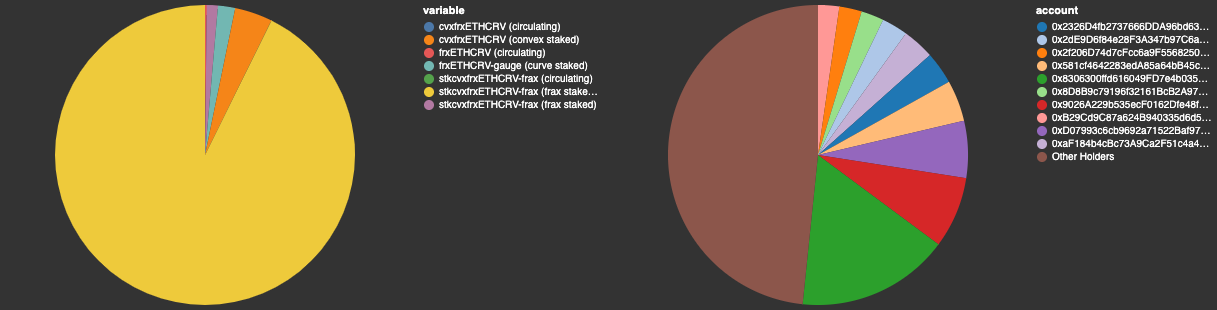

In [171]:
d = df.reset_index()[['index', 'account', 'total_frxETHCRV']].reset_index()
top_n_holders = 10
d_top_n = (
    pd.concat([
        d.loc[d.index < top_n_holders][['account', 'total_frxETHCRV']].rename(columns={'total_frxETHCRV': 'frxETHCRV'}), 
        pd.DataFrame([{
            "account": "Other Holders", 
            "frxETHCRV": d.loc[d.index >= top_n_holders].total_frxETHCRV.sum()}
        ])
    ])
    .sort_values('frxETHCRV').reset_index(drop=True).reset_index()
)

(
    alt.hconcat(
        alt.Chart(
            pd.melt(df, id_vars='account', value_vars=value_cols).reset_index()
            .groupby('variable')['value'].sum().reset_index()
            .sort_values('value').reset_index(drop=True).reset_index()
        )
        .transform_joinaggregate(amount_total="sum(value)")
        .transform_calculate(fraction="datum.value / datum.amount_total")
        .mark_arc()
        .encode(
            theta="value:Q", 
            color="variable:N", 
            order="index:O", 
            tooltip=[
                alt.Tooltip("variable:N"), 
                alt.Tooltip("value:Q", format=",d", title="frxETHCRV"),
                alt.Tooltip("fraction:Q", format=".1%", title="Share"),
            ]
        ),
        alt.Chart(d_top_n)
        .transform_joinaggregate(total="sum(frxETHCRV)")
        .transform_calculate(fraction="datum.frxETHCRV / datum.total")
        .mark_arc()
        .encode(
            theta=alt.Theta("frxETHCRV:Q"), 
            color=alt.Color("account:N", scale=alt.Scale(range=colors_28)), 
            order="index:O", 
            tooltip=[
                alt.Tooltip("account:N"), 
                alt.Tooltip("frxETHCRV:Q", format=",d", title="frxETHCRV"),
                alt.Tooltip("fraction:Q", format=".1%", title="Share"),
            ]
        ) 
    )
    .resolve_scale(color="independent")
    .resolve_legend(color="independent")
)

In [172]:
precision = 2
pd.set_option('display.float_format', lambda x: f'%.{precision}f' % x)
ddf(
    df.loc[df.total_frxETHCRV >= 10**(-1*precision)].sort_values('total_frxETHCRV', ascending=False).head()
)

,account,frxETHCRV-gauge (curve staked),cvxfrxETHCRV (convex staked),stkcvxfrxETHCRV-frax (frax staked),stkcvxfrxETHCRV-frax (frax staked via convex),frxETHCRV (circulating),cvxfrxETHCRV (circulating),stkcvxfrxETHCRV-frax (circulating),total_frxETHCRV
0,0x8306300ffd616049FD7e4b0354a64Da835c1A81C,0.00,0.00,0.00,8500.90,0.00,0.00,0.00,8500.90
1,0x9026A229b535ecF0162Dfe48fDeb3c75f7b2A7AE,0.00,0.00,0.00,3965.32,0.00,0.00,0.00,3965.32
2,0xD07993c6cb9692a71522Baf970A31069034dF2B0,0.00,0.00,0.00,3170.97,0.00,0.00,0.00,3170.97
3,0x581cf4642283edA85a64bB45cd226854415AB830,0.00,0.00,0.00,2286.43,0.00,0.00,0.00,2286.43
4,0x2326D4fb2737666DDA96bd6314e3D4418246cFE8,0.00,0.00,0.00,1801.32,0.00,0.00,0.00,1801.32


In [173]:
# - 3 largest deposits
# - time of first deposit 
# - Notable wallets that deposited
df = df.sort_values('total_frxETHCRV', ascending=False).reset_index(drop=True) 
ens = {
    "0x9026A229b535ecF0162Dfe48fDeb3c75f7b2A7AE": "czsamsunsb.eth", 
    "0x2dE9D6f84e28F3A347b97C6a3Db51D366E65bA4C": "safefarmer.eth", 
    "0x2f206D74d7cFcc6a9F556825034eB110a572AD62": "uhtearyum.eth", 
    "0xB29Cd9C87a624B940335d6d5e1D4aADf7D95bEeC": "adamant.eth", 
}
df['ens'] = df.account.apply(lambda a: ens.get(a))
ddf(df.head(10))

,account,frxETHCRV-gauge (curve staked),cvxfrxETHCRV (convex staked),stkcvxfrxETHCRV-frax (frax staked),stkcvxfrxETHCRV-frax (frax staked via convex),frxETHCRV (circulating),cvxfrxETHCRV (circulating),stkcvxfrxETHCRV-frax (circulating),total_frxETHCRV,ens
0,0x8306300ffd616049FD7e4b0354a64Da835c1A81C,0.00,0.00,0.00,8500.90,0.00,0.00,0.00,8500.90,None
1,0x9026A229b535ecF0162Dfe48fDeb3c75f7b2A7AE,0.00,0.00,0.00,3965.32,0.00,0.00,0.00,3965.32,czsamsunsb.eth
2,0xD07993c6cb9692a71522Baf970A31069034dF2B0,0.00,0.00,0.00,3170.97,0.00,0.00,0.00,3170.97,None
3,0x581cf4642283edA85a64bB45cd226854415AB830,0.00,0.00,0.00,2286.43,0.00,0.00,0.00,2286.43,None
4,0x2326D4fb2737666DDA96bd6314e3D4418246cFE8,0.00,0.00,0.00,1801.32,0.00,0.00,0.00,1801.32,None
5,0xaF184b4cBc73A9Ca2F51c4a4d80eD67a2578E9F4,0.00,0.00,0.00,1772.04,0.00,0.00,0.00,1772.04,None
6,0x2dE9D6f84e28F3A347b97C6a3Db51D366E65bA4C,0.00,0.00,0.00,1453.31,0.00,0.00,0.00,1453.31,safefarmer.eth
7,0x8D8B9c79196f32161BcB2A9728D274B3b45eB9AF,0.00,0.00,0.00,1259.20,0.00,0.00,0.00,1259.20,None
8,0x2f206D74d7cFcc6a9F556825034eB110a572AD62,0.00,0.00,0.00,1249.42,0.00,0.00,0.00,1249.42,uhtearyum.eth
9,0xB29Cd9C87a624B940335d6d5e1D4aADf7D95bEeC,0.00,0.00,0.00,1179.44,0.00,0.00,0.00,1179.44,adamant.eth


19320803.886743303


/opt/miniconda3/envs/flywheel/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


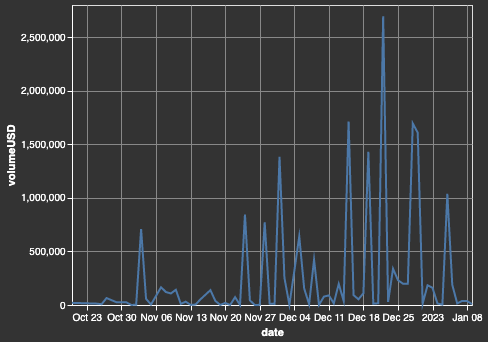

In [174]:
# - total FrxETH/sfrxeth volume 
from subgrounds import Subgrounds

sg = Subgrounds()
sg_curve_vol = sg.load_subgraph(url_subgraphs.convex.curve_vol_mainnet)
q = sg_curve_vol.Query.swapVolumeSnapshots(where={"pool": "0xa1f8a6807c402e4a15ef4eba36528a3fed24e577"}, first=1000)
df_frxeth_pool = sg.query_df([q.timestamp, q.volumeUSD])
df_frxeth_pool = remove_prefix(df_frxeth_pool, 'swapVolumeSnapshots_')
df_frxeth_pool.timestamp = pd.to_datetime(df_frxeth_pool.timestamp, unit='s')
df_frxeth_pool['date'] = pd.to_datetime(df_frxeth_pool.timestamp.dt.date)
df_frxeth_pool = df_frxeth_pool.groupby("date").max().reset_index()[['date', 'volumeUSD']]
df_frxeth_pool.volumeUSD /= 2
print(df_frxeth_pool.volumeUSD.sum()) 
alt.Chart(df_frxeth_pool).mark_line().encode(x="date:T", y="volumeUSD:Q")

In [175]:
addrs = [
    '0x9026A229b535ecF0162Dfe48fDeb3c75f7b2A7AE', # (czsamsunsb.eth)
    '0xD07993c6cb9692a71522Baf970A31069034dF2B0',
    '0x581cf4642283edA85a64bB45cd226854415AB830',
] 

In [178]:
qattrs = ['id', 'amount', 'timestamp', 'user.address']
# deposits into the convex staking contract for curve lp tokens 
q_deposits = sg_curve_pools.Query.deposits(first=100000, where={'poolid_': {'swap': ADDRESS_CURVE_POOL_FRXETH_ETH}})
df_deposits = query_attrs(sg, q_deposits, qattrs)
df_deposits = remove_prefix(df_deposits, 'deposits_') 
df_deposits.timestamp = pd.to_datetime(df_deposits.timestamp, unit='s')
# current deposited amount per account in convex staking contract for curve lp tokens 
# df_convex = pd.concat([df_deposits, df_withdrawals])
# df_convex = df_convex.groupby('user_address')['amount'].sum().reset_index()
# df_convex = df_convex.loc[df_convex.amount != 0].sort_values('amount', ascending=False).reset_index(drop=True)
# df_convex.amount /= 1e18
# df_convex['platform'] = 'convex-curve'
# df_convex = df_convex.rename(columns={'user_address': 'account'})
# df_convex.head()
# return df_convex 

In [179]:
df_deposits.head()

,id,amount,timestamp,user_address
0,0x000492fab570bb6fe3b1e30c3db2df3d4d252bcc711e...,24987560277428693493,2022-12-05 09:49:23,0x4659d5ff63a1e1edd6d5dd9cc315e063c95947d0
1,0x001c17c0d86776299dc1a8cdaa888964971b094a32f4...,320389970965389464563,2023-01-02 22:22:59,0x4659d5ff63a1e1edd6d5dd9cc315e063c95947d0
2,0x007562ec43ffc63894d5b30e812bd65858605829090a...,1019416498333776300,2022-11-26 01:46:59,0x0f903834187d37ff29dc2d607dd9fb50eb36b2b5
3,0x009154d4001e53605ee80928c38a32c63eb9f6278065...,551915891711220087824,2022-12-06 04:34:11,0x4659d5ff63a1e1edd6d5dd9cc315e063c95947d0
4,0x012a7730ff93a15624d92a94a9a8a5fa9ab8e2ff7b28...,6799529641957293310,2022-11-17 06:06:47,0x4659d5ff63a1e1edd6d5dd9cc315e063c95947d0


In [180]:
for a in addrs: 
    d = df_deposits.loc[df_deposits.user_address.str.lower() == a.lower()]
    print(a, d.timestamp)

0x9026A229b535ecF0162Dfe48fDeb3c75f7b2A7AE 585   2022-12-02 05:03:23
Name: timestamp, dtype: datetime64[ns]
0xD07993c6cb9692a71522Baf970A31069034dF2B0 Series([], Name: timestamp, dtype: datetime64[ns])
0x581cf4642283edA85a64bB45cd226854415AB830 Series([], Name: timestamp, dtype: datetime64[ns])
